In [1]:
import os
import re
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pandas import DataFrame, concat

import torch
from torchinfo import summary
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from models.ae import AE
from models.dnnAE_trainer import DNNTrainer

In [2]:
# 5 levels of attack intensity: levels 5, 6, 7, 8, 9.
# Level 5 is the most severe and level 9 the least severe
attack_intensity = 9
# Path to all dataset
DATASET_PATH = os.path.join(os.getcwd(), 'data')
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.path.join(os.getcwd(), 'checkpoints')

In [3]:
# seed 13 for I5, 17 for I7
seed = 29
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **DNN Data Generation**

In [4]:
ATTACK_DATA_PATH = os.path.join(DATASET_PATH, f'I{attack_intensity}')
Z = dict()
for filename in tqdm(os.listdir(ATTACK_DATA_PATH), desc='Reading data ... '):
    fname = os.path.join(ATTACK_DATA_PATH, filename)
    data = loadmat(fname)
    att_type = int(re.findall(r'\d+', filename)[0])
    Z[att_type] = data['Z']

NORMAL_DATA_FILENAME = 'Normal2.mat'
data = loadmat(os.path.join(DATASET_PATH, NORMAL_DATA_FILENAME))
Z[0] = data['Z']

Z = dict(sorted(Z.items()))

Reading data ... : 100%|██████████| 3/3 [00:00<00:00,  6.35it/s]


In [5]:
latent_dim = 118
no_residual = 1
batch_size = 16

In [6]:
ae = AE(latent_dims=latent_dim).to(device)
ae.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, 'ae_0%.pt')))

<All keys matched successfully>

In [7]:
ae.eval()
Res = dict()
for k, v in tqdm(Z.items(), desc="Generating residuals ... "):
    z = torch.tensor(v, dtype=torch.float32).to(device)
    # AE residuals
    r = (ae(z) - z).detach().cpu()
    Res[k] = torch.stack([r], dim=1)

Generating residuals ... : 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


In [8]:
def get_data(train_size):
    X, y = dict(), dict()
    trainX, testX = [], []
    trainY, testY = [], []
    for k, v in Res.items():
        y_i = k * torch.ones((v.shape[0]), dtype=torch.long)
        trainX.append(v[:train_size])
        testX.append(v[train_size:])
        trainY.append(y_i[:train_size])
        testY.append(y_i[train_size:])
    X['train'] = torch.cat(trainX, dim=0)
    X['test'] = torch.cat(testX, dim=0)
    y['train'] = F.one_hot(torch.cat(trainY, dim=0)).float()
    y['test'] = F.one_hot(torch.cat(testY, dim=0)).float()
    return X, y

In [9]:
class ResidualData():
    def __init__(self, X, y):
        self.X, self.y = X, y
    
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# **Train DNN**

In [10]:
batch_size = 16
epochs = 1000
train_size = int(len(Res[0]) * 0.85)
epochs = 1000
lr = 1e-1
scheduler = True
es_patience = 10

In [11]:
X, y = get_data(train_size)
training = ResidualData(X['train'], y['train'])
test = ResidualData(X['test'], y['test'])
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [12]:
X['train'].shape

torch.Size([11176, 1, 358])

In [13]:
trainer = DNNTrainer(no_residuals=no_residual, lr=lr, 
                     lr_scheduler=scheduler,
                     es_patience=es_patience, 
                     checkpoint_name=f'dnnAE_{attack_intensity}.pt', 
                     seed=seed)

In [14]:
summary(trainer.dnn, (1, 1, 358))

Layer (type:depth-idx)                   Output Shape              Param #
DNN                                      [1, 4]                    --
├─Linear: 1-1                            [1, 1, 128]               45,952
├─Linear: 1-2                            [1, 1, 64]                8,256
├─Linear: 1-3                            [1, 1, 32]                2,080
├─Linear: 1-4                            [1, 16]                   528
├─Linear: 1-5                            [1, 4]                    68
Total params: 56,884
Trainable params: 56,884
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.23
Estimated Total Size (MB): 0.23

In [15]:
dnn, loss, val_loss, acc, val_acc = trainer.train(train_dl=train_dl,
                                                  val_dl=test_dl,
                                                  epochs=epochs)

Epoch 1/1000: [Loss: 1.4917], [Accuracy: 0.2509], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (inf --> 1.493668).  Saving model ...
Epoch 2/1000: [Loss: 1.4903], [Accuracy: 0.2530], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (1.493668 --> 1.493668).  Saving model ...
Epoch 3/1000: [Loss: 1.4935], [Accuracy: 0.2496], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (1.493668 --> 1.493668).  Saving model ...
Epoch 4/1000: [Loss: 1.5036], [Accuracy: 0.2395], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
EarlyStopping counter: 1 out of 10
Epoch 5/1000: [Loss: 1.4969], [Accuracy: 0.2465], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
EarlyStopping counter: 2 out of 10
Epoch 6/1000: [Loss: 1.4939], [Accuracy: 0.2496], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
Validation loss decreased (1.493668 --> 1.493668).  Saving model ...
Epoch 7/1000: [Loss: 1.4985], [Accuracy: 0.2453], [Val_Loss: 1.4937], [Val_Accuracy: 0.2500]
EarlySto

In [16]:
def plot_learning(loss, val_loss):
    fig, axs = plt.subplots(figsize=(6,4))
    axs.plot(loss, color='r', label='Training')
    axs.plot(val_loss, color='b', label='Validation')
    axs.set_title('Training vs. Validation Loss')
    plt.legend()
    # plt.savefig('acc.pdf', format='pdf', dpi=1200)
    plt.show()

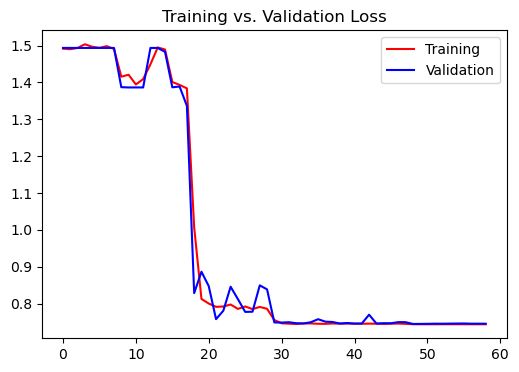

In [17]:
plot_learning(loss, val_loss)

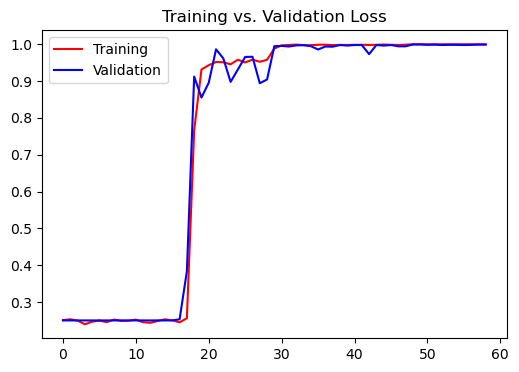

In [18]:
plot_learning(acc, val_acc)

In [19]:
dnn.eval()
preds = dnn(X['test'].to(device))
preds

tensor([[9.9997e-01, 2.5016e-10, 7.7053e-08, 2.6132e-05],
        [9.9997e-01, 4.0562e-10, 1.0896e-07, 3.2635e-05],
        [9.9998e-01, 1.1045e-10, 4.1438e-08, 1.5713e-05],
        ...,
        [3.4444e-07, 7.2912e-06, 1.3038e-05, 9.9998e-01],
        [8.1945e-07, 4.1824e-06, 1.1024e-05, 9.9998e-01],
        [3.5814e-06, 6.7377e-06, 2.0618e-05, 9.9997e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [20]:
dnn.eval()
pred_train = dnn(X['train'].to(device))
pred_train

tensor([[1.0000e+00, 6.2139e-12, 5.2093e-09, 4.0117e-06],
        [1.0000e+00, 2.1283e-12, 2.3890e-09, 2.3475e-06],
        [1.0000e+00, 2.5129e-12, 2.6560e-09, 2.4134e-06],
        ...,
        [4.2637e-06, 6.5892e-06, 2.1104e-05, 9.9997e-01],
        [2.1996e-05, 2.0157e-05, 6.1616e-05, 9.9990e-01],
        [9.4463e-06, 1.2950e-05, 3.8743e-05, 9.9994e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [21]:
trainer.accuracy(preds, y['test'].to(device))

tensor(0.9995, device='cuda:0')

In [22]:
trainer.accuracy(pred_train, y['train'].to(device))

tensor(1., device='cuda:0')

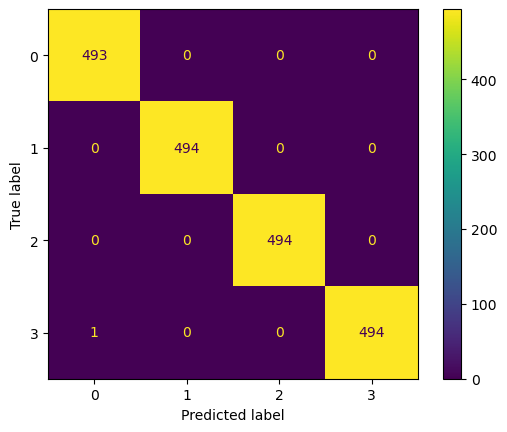

In [23]:
# test
preds = torch.argmax(preds, dim=1)
preds = preds.detach().cpu().numpy()
target = torch.argmax(y['test'], dim=1)
cm = confusion_matrix(preds, target, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

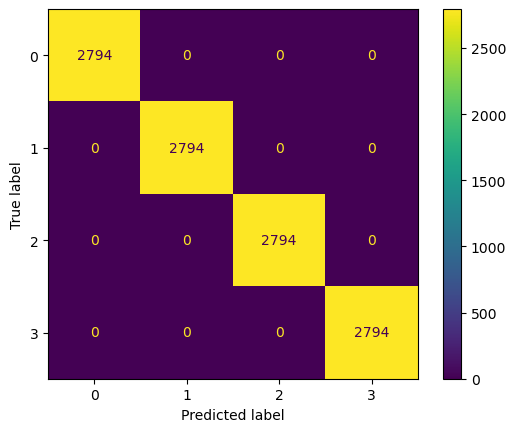

In [24]:
# train
pred_train = torch.argmax(pred_train, dim=1)
pred_train = pred_train.detach().cpu().numpy()
target = torch.argmax(y['train'], dim=1)
cm = confusion_matrix(pred_train, target, labels=[0,1,2,3])
ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3]).plot()

# **Mid-layer Plots**

In [25]:
activation = dict()
def get_activation(name):
    def hook(model, in_data, out_data):
        activation[name] = out_data.detach()
    return hook

In [26]:
dnn.eval()
dnn.linear3.register_forward_hook(get_activation('linear3'))
out32 = dnn(X['test'].to(device))
l3 = activation['linear3']
l3.shape

torch.Size([1976, 1, 32])

In [27]:
def add_headers(fig,
                *,
                row_headers=None,
                col_headers=None,
                row_pad=1,
                col_pad=5,
                rotate_row_headers=True,
                **text_kwargs):
    axes = fig.get_axes()
    for ax in axes:
        sbs = ax.get_subplotspec()
        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
            col_headers[sbs.colspan.start],
            xy=(0.5, 1),
            xytext=(0, col_pad),
            xycoords="axes fraction",
            textcoords="offset points",
            ha="center",
            va="baseline",
            **text_kwargs,
            )
        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
            row_headers[sbs.rowspan.start],
            xy=(0, 0.5),
            xytext=(-ax.yaxis.labelpad - row_pad, 0),
            xycoords=ax.yaxis.label,
            textcoords="offset points",
            ha="right",
            va="center",
            rotation=rotate_row_headers * 90,
            **text_kwargs,
            )

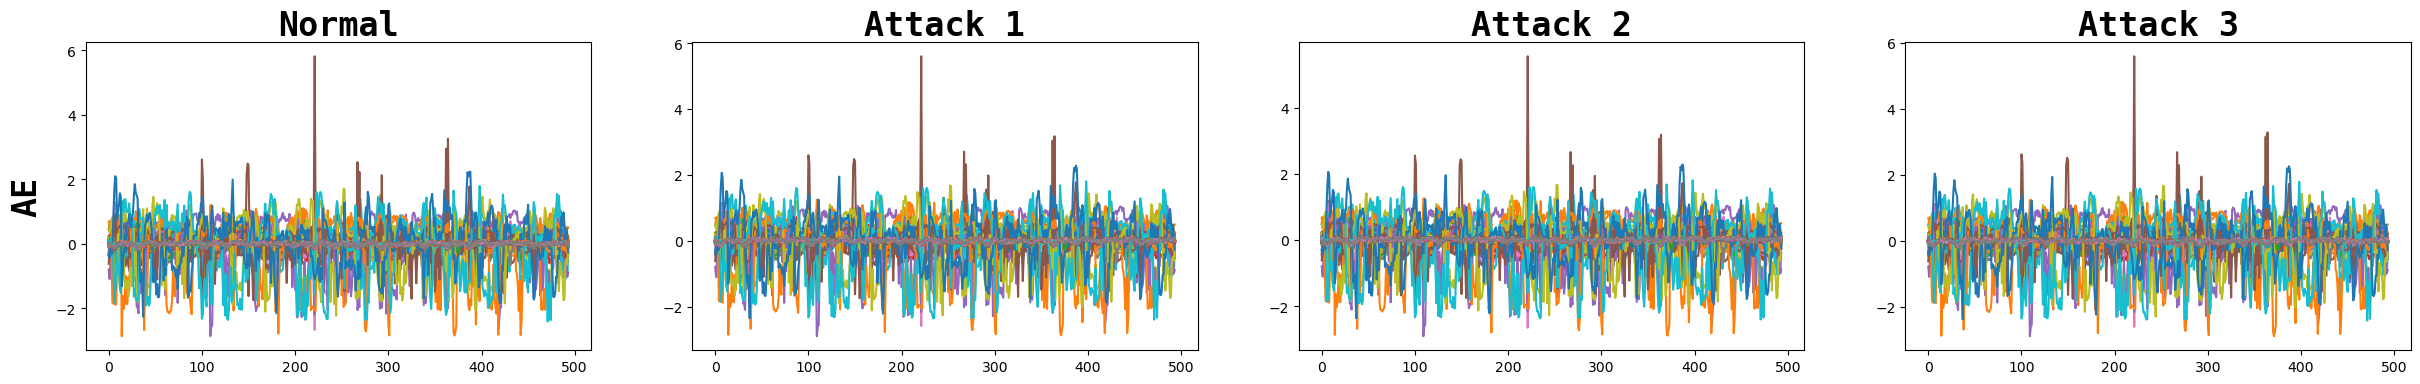

In [28]:
dataset_size = int(len(X['test']) / 4)
fig, ax = plt.subplots(1, 4, figsize=(30,4))
for i in range(358):
    # no attack
    ax[0].plot(X['test'][0:dataset_size, 0, i])
    
    # attacl label 1
    ax[1].plot(X['test'][dataset_size:2*dataset_size, 0, i])
    
    # attack label 2
    ax[2].plot(X['test'][2*dataset_size:3*dataset_size, 0, i])
    
    # attack label 3
    ax[3].plot(X['test'][3*dataset_size:, 0, i])
font_kwargs = dict(fontfamily="monospace", fontweight="bold", fontsize=24)
add_headers(fig, 
            col_headers=['Normal','Attack 1','Attack 2','Attack 3'], 
            row_headers=['AE'], 
            **font_kwargs)
# plt.savefig('./img/test-358-.pdf', format='pdf', dpi=1200)
plt.show()

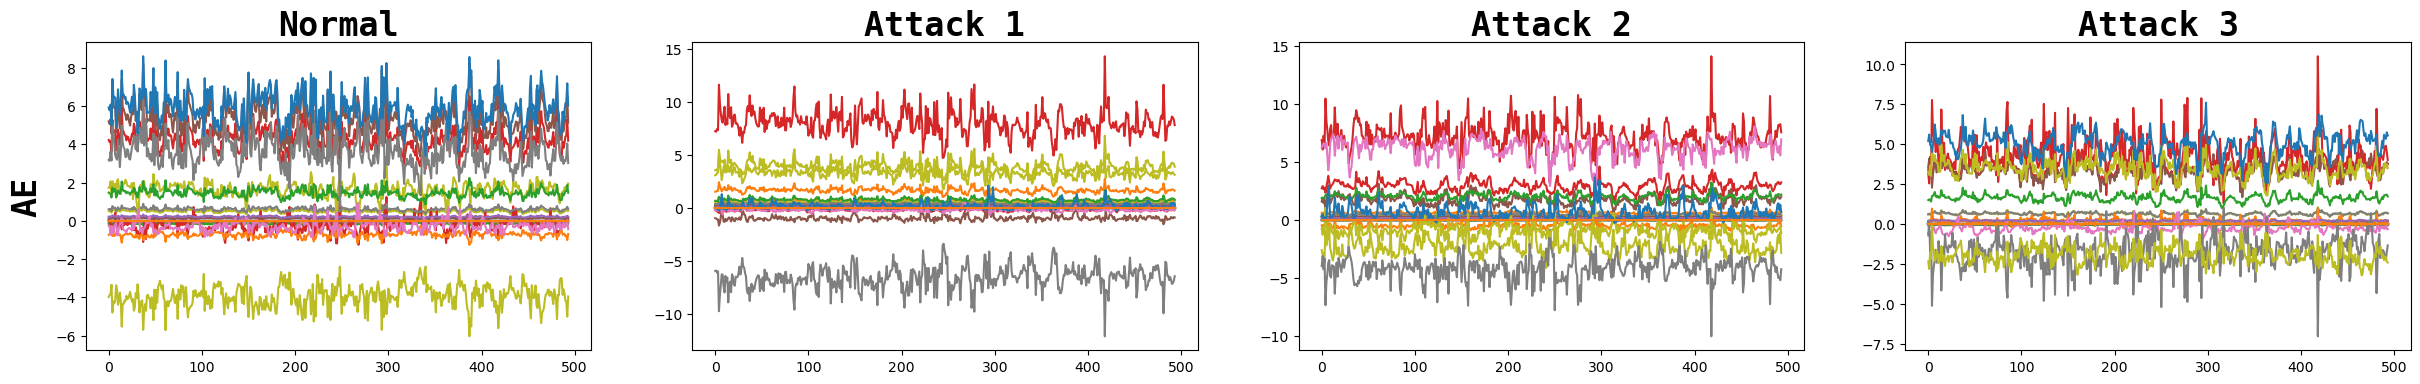

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(30,4))
for i in range(32):
    # no attack
    ax[0].plot(l3.cpu()[0:dataset_size, 0, i])
    
    # attacl label 1
    ax[1].plot(l3.cpu()[dataset_size:2*dataset_size, 0, i])
    
    # attack label 2
    ax[2].plot(l3.cpu()[2*dataset_size:3*dataset_size, 0, i])
    
    # attack label 3
    ax[3].plot(l3.cpu()[3*dataset_size:, 0, i])
font_kwargs = dict(fontfamily="monospace", fontweight="bold", fontsize=24)
add_headers(fig, 
            col_headers=['Normal','Attack 1','Attack 2','Attack 3'], 
            row_headers=['AE'], 
            **font_kwargs)
# plt.savefig('./img/test-32-.pdf', format='pdf', dpi=1200)
plt.show()

# **Probabilities**

In [30]:
dnn.eval()
dnn.linear5.register_forward_hook(get_activation('linear5'))
outSample = dnn(X['test'].to(device))
lSample = F.softmax(activation['linear5'], dim=1)
lSample.shape

torch.Size([1976, 4])

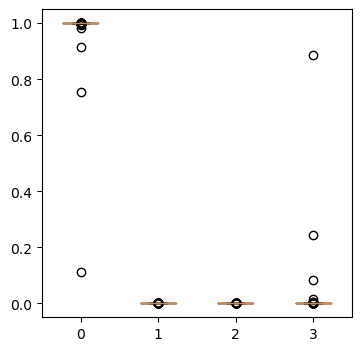

In [31]:
fig, ax = plt.subplots(figsize=(4,4))
xTick = list(range(4))
ax.boxplot(torch.transpose(lSample[:dataset_size,:],0,1).cpu())
ax.set_xticklabels(xTick)
plt.show()

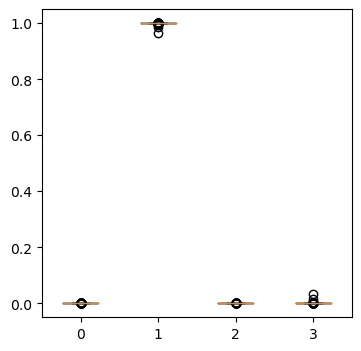

In [32]:
fig, ax = plt.subplots(figsize=(4,4))
xTick = list(range(4))
ax.boxplot(torch.transpose(lSample[dataset_size:2*dataset_size,:],0,1).cpu())
ax.set_xticklabels(xTick)
plt.show()

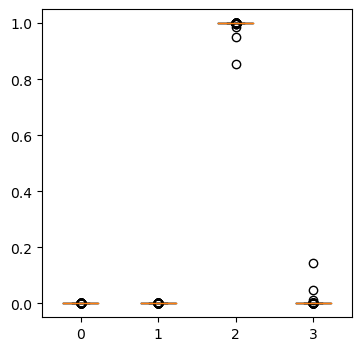

In [33]:
fig, ax = plt.subplots(figsize=(4,4))
xTick = list(range(4))
ax.boxplot(torch.transpose(lSample[2*dataset_size:3*dataset_size,:],0,1).cpu())
ax.set_xticklabels(xTick)
plt.show()

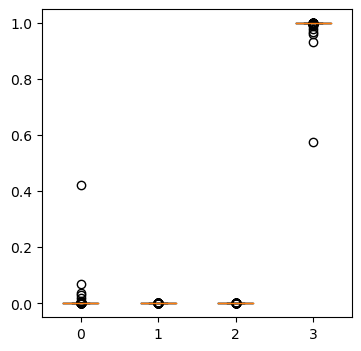

In [34]:
fig, ax = plt.subplots(figsize=(4,4))
xTick = list(range(4))
ax.boxplot(torch.transpose(lSample[3*dataset_size:,:],0,1).cpu())
ax.set_xticklabels(xTick)
plt.show()

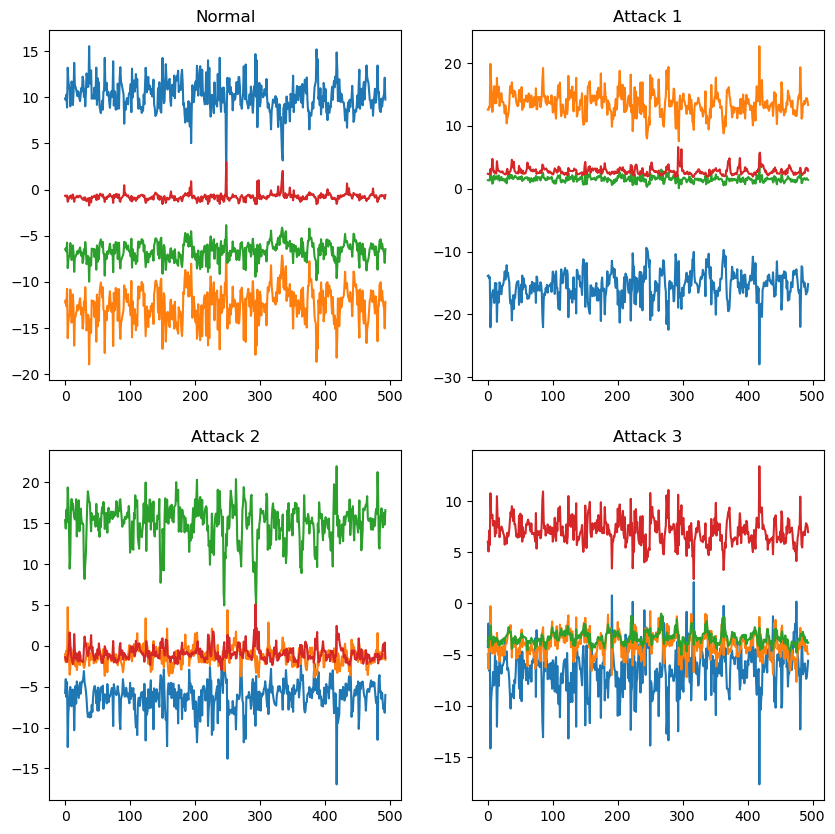

In [35]:
lSample = activation['linear5']
fig, ax = plt.subplots(2, 2, figsize=(10,10))
for i in range(4):
    ax[0,0].plot(lSample[:dataset_size,i].cpu())
    ax[0,1].plot(lSample[dataset_size:2*dataset_size,i].cpu())
    ax[1,0].plot(lSample[2*dataset_size:3*dataset_size,i].cpu())
    ax[1,1].plot(lSample[3*dataset_size:,i].cpu())
ax[0,0].set_title('Normal') 
ax[0,1].set_title('Attack 1')
ax[1,0].set_title('Attack 2')
ax[1,1].set_title('Attack 3')
# plt.savefig('./img/test-4.pdf', format='pdf', dpi=1200)
plt.show()

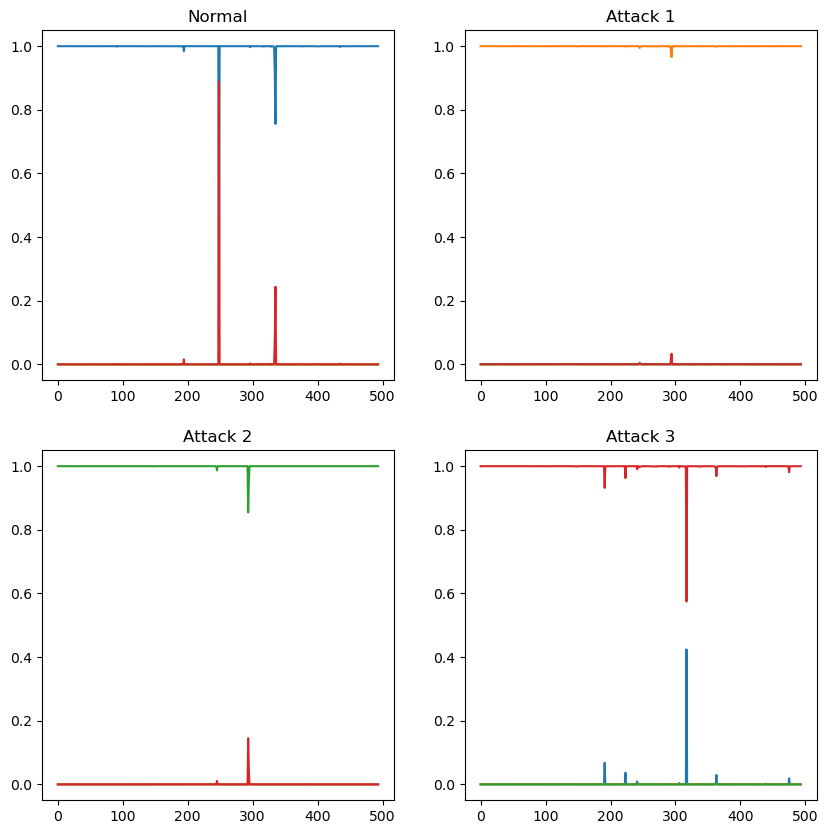

In [36]:
lSample = F.softmax(activation['linear5'], dim=1)
fig, ax = plt.subplots(2, 2, figsize=(10,10))
for i in range(4):
    ax[0,0].plot(lSample[:dataset_size,i].cpu())
    ax[0,1].plot(lSample[dataset_size:2*dataset_size,i].cpu())
    ax[1,0].plot(lSample[2*dataset_size:3*dataset_size,i].cpu())
    ax[1,1].plot(lSample[3*dataset_size:,i].cpu())
ax[0,0].set_title('Normal') 
ax[0,1].set_title('Attack 1')
ax[1,0].set_title('Attack 2')
ax[1,1].set_title('Attack 3')
# plt.savefig('./img/test-p-4.pdf', format='pdf', dpi=1200)
plt.show()